In [305]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).







# Introduction

Funnel Analysis:
The goal is to perform funnel analysis for an e-commerce website.

Typically, websites have a clear path to conversion: for instance, you land on the home page, then you search, select a product and buy it. At each of these steps, some users will drop off and leave the site. The sequence of pages that leads to conversion is called ‘funnel’ .

Data Science can have a tremendous impact on funnel optimization. Funnel analysis allows to understand where/when our users abandon the website. It gives crucial insights on user behavior and on ways to improve the user experience as well as it often allows to discover bugs.

Understanding these drop-offs is crucial. Funnel analysis provides:

* **User behavior insights** – how customers interact with the site.
* **Optimization opportunities** – identifying stages where most users abandon the funnel.
* **Business impact** – improving conversions by fixing UX issues, content gaps, or technical bugs.

In this project, we aim to:

1. Perform funnel analysis on e-commerce user journey data.
2. Calculate the conversion rate at each stage of the funnel.
3. Analyze monthly trends in conversion rates to see how user behavior changes over time.
4. Provide actionable insights on where improvements can be made to reduce drop-offs and improve overall conversions.



In [306]:
import pandas as pd

# Load datasets
home = pd.read_csv("/content/drive/MyDrive/Funnel-data/home_page_table.csv")
search = pd.read_csv("/content/drive/MyDrive/Funnel-data/search_page_table.csv")
payment = pd.read_csv("/content/drive/MyDrive/Funnel-data/payment_page_table.csv")
confirm = pd.read_csv("/content/drive/MyDrive/Funnel-data/payment_confirmation_table.csv")
user = pd.read_csv("/content/drive/MyDrive/Funnel-data/user_table.csv")



In [307]:
print(home.head())
print(search.head())
print(payment.head())
print(confirm.head())
print(user.head())


   user_id       page
0   313593  home_page
1   468315  home_page
2   264005  home_page
3   290784  home_page
4   639104  home_page
   user_id         page
0    15866  search_page
1   347058  search_page
2   577020  search_page
3   780347  search_page
4   383739  search_page
   user_id          page
0   253019  payment_page
1   310478  payment_page
2   304081  payment_page
3   901286  payment_page
4   195052  payment_page
   user_id                       page
0   123100  payment_confirmation_page
1   704999  payment_confirmation_page
2   407188  payment_confirmation_page
3   538348  payment_confirmation_page
4   841681  payment_confirmation_page
   user_id        date   device     sex
0   450007  2015-02-28  Desktop  Female
1   756838  2015-01-13  Desktop    Male
2   568983  2015-04-09  Desktop    Male
3   190794  2015-02-18  Desktop  Female
4   537909  2015-01-15  Desktop    Male


In [308]:
print(home.shape)
print(payment.shape)
print(search.shape)
print(confirm.shape)
print(user.shape)

(90400, 2)
(6030, 2)
(45200, 2)
(452, 2)
(90400, 4)


In [309]:
print(home.isnull().sum())
print(payment.isnull().sum())
print(search.isnull().sum())
print(confirm.isnull().sum())
print(user.isnull().sum())

user_id    0
page       0
dtype: int64
user_id    0
page       0
dtype: int64
user_id    0
page       0
dtype: int64
user_id    0
page       0
dtype: int64
user_id    0
date       0
device     0
sex        0
dtype: int64


## **Merging Datasets**

In [310]:
merged_df = user\
    .merge(home, on="user_id", how="left", suffixes=("_user", "_home")) \
    .merge(search, on="user_id", how="left", suffixes=("", "_search")) \
    .merge(payment, on="user_id", how="left", suffixes=("", "_payment")) \
    .merge(confirm, on="user_id", how="left", suffixes=("", "_confirmation"))


print("\nMerged Dataset:")
display(merged_df.head())



Merged Dataset:


,user_id,date,device,sex,page,page_search,page_payment,page_confirmation
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN


In [311]:
merged_df = merged_df.fillna(0)
display(merged_df.head())

,user_id,date,device,sex,page,page_search,page_payment,page_confirmation
0,450007,2015-02-28,Desktop,Female,home_page,0,0,0
1,756838,2015-01-13,Desktop,Male,home_page,0,0,0
2,568983,2015-04-09,Desktop,Male,home_page,search_page,0,0
3,190794,2015-02-18,Desktop,Female,home_page,search_page,0,0
4,537909,2015-01-15,Desktop,Male,home_page,0,0,0


**Calculating Count of Users at Each stage**

In [312]:
home_users = merged_df['user_id'].nunique()
search_users = merged_df[merged_df['page_search'] != 0]['user_id'].nunique()
payment_users = merged_df[merged_df['page_payment'] != 0]['user_id'].nunique()
confirm_users = merged_df[merged_df['page_confirmation'] != 0]['user_id'].nunique()


print("Visited Home Page:", home_users)
print("Visited Search Page:", search_users)
print("Reached Payment Page:", payment_users)
print("Completed Payment:", confirm_users)

Visited Home Page: 90400
Visited Search Page: 45200
Reached Payment Page: 6030
Completed Payment: 452


In [313]:
funnel_data = pd.DataFrame({
    'Stage': ['Home Page', 'Search Page', 'Payment Page', 'Confirmation'],
    'Users': [home_users, search_users, payment_users, confirm_users]
})

funnel_data


,Stage,Users
0,Home Page,90400
1,Search Page,45200
2,Payment Page,6030
3,Confirmation,452


In [314]:
home_to_search = (search_users / home_users) * 100
search_to_payment = (payment_users / search_users) * 100
payment_to_confirm = (confirm_users / payment_users) * 100
overall_conversion = (confirm_users / home_users) * 100

print(f"Home → Search Conversion: {home_to_search:.2f}%")
print(f"Search → Payment Conversion: {search_to_payment:.2f}%")
print(f"Payment → Confirmation Conversion: {payment_to_confirm:.2f}%")
print(f"Overall Funnel Conversion: {overall_conversion:.2f}%")

Home → Search Conversion: 50.00%
Search → Payment Conversion: 13.34%
Payment → Confirmation Conversion: 7.50%
Overall Funnel Conversion: 0.50%


In [315]:
overall_drop_off = 100 - overall_conversion

overall_rates_df = pd.DataFrame({
    'Metric': ['Overall Funnel Drop-off Rate', 'Overall Funnel Conversion Rate'],
    'Rate (%)': [overall_drop_off, overall_conversion]
})


display(overall_rates_df)

,Metric,Rate (%)
0,Overall Funnel Drop-off Rate,99.5
1,Overall Funnel Conversion Rate,0.5


In [316]:
conversion_summary = pd.DataFrame({
    "Stage": ["Home→Search", "Search→Payment", "Payment→Confirm", "Overall"],
    "Conversion Rate (%)": [home_to_search, search_to_payment, payment_to_confirm, overall_conversion],
    "Drop-off Rate (%)": [100-home_to_search, 100-search_to_payment, 100-payment_to_confirm, overall_drop_off]
})
display(conversion_summary)


,Stage,Conversion Rate (%),Drop-off Rate (%)
0,Home→Search,50.000000,50.000000
1,Search→Payment,13.340708,86.659292
2,Payment→Confirm,7.495854,92.504146
3,Overall,0.500000,99.500000


From the Rates of both drop off and conversion, we can see that there is a significant drop-off of users through the funnel. Only a small percentage of users who land on the home page ultimatelu complete a purchase.

This indicates that there are  major areas for improvements in the user journey to increase conversion.

only 0.5% of users complete the purchase, with the biggest drops at Search→Payment (86.7%) and Payment→Confirmation (92.5%)

## **Detailed Funnel Analysis with Drop-off Rates.**

calculating the number of users at each stage, the overall conversion rate from the home page, the stage-by-stage conversion rate, and the drop-off rate for each stage.


In [317]:
stages = ['page','page_search','page_payment','page_confirmation']
# Correctly count users at each stage by checking for non-zero values
counts = {
    'page': merged_df[merged_df['page'] != 0]['user_id'].nunique(),
    'page_search': merged_df[merged_df['page_search'] != 0]['user_id'].nunique(),
    'page_payment': merged_df[merged_df['page_payment'] != 0]['user_id'].nunique(),
    'page_confirmation': merged_df[merged_df['page_confirmation'] != 0]['user_id'].nunique()
}

rows = []
stage_names = ['Home Page', 'Search Page', 'Payment Page', 'Confirmation'] # More descriptive names
for i in range(len(stages)-1):
    a = stages[i]; b = stages[i+1]
    prev = counts[a]; nxt = counts[b]
    abs_drop = prev - nxt
    drop_pct = (abs_drop / prev * 100) if prev else 0
    conv_pct = (nxt / prev * 100) if prev else 0
    rows.append({
        'from_to': f"{stage_names[i]} → {stage_names[i+1]}", # Use descriptive names
        'prev': prev,
        'next': nxt,
        'abs_drop': abs_drop,
        'drop_pct': round(drop_pct,2),
        'conv_pct': round(conv_pct,2)
    })

import pandas as pd
pd.DataFrame(rows)

,from_to,prev,next,abs_drop,drop_pct,conv_pct
0,Home Page → Search Page,90400,45200,45200,50.00,50.00
1,Search Page → Payment Page,45200,6030,39170,86.66,13.34
2,Payment Page → Confirmation,6030,452,5578,92.50,7.50


## **Detailed Funnel Analysis with Drop-off Rates and Conversion Rates.**

calculating the number of users at each stage, the overall conversion rate from the home page, the stage-by-stage conversion rate, and the drop-off rate for each stage.


In [318]:

funnel_counts = {
    'Home Page': home_users,
    'Search Page': search_users,
    'Payment Page': payment_users,
    'Confirmation Page': confirm_users
}


funnel_df = pd.DataFrame.from_dict(funnel_counts, orient='index', columns=['Users'])


funnel_df['Conversion Rate (%)'] = (funnel_df['Users'] / funnel_df['Users'].iloc[0]) * 100

funnel_df['Stage Conversion Rate (%)'] = funnel_df['Users'].pct_change().fillna(1).apply(lambda x: (1 - abs(x)) * 100)
funnel_df['Drop-off Rate (%)'] = funnel_df['Stage Conversion Rate (%)'].apply(lambda x: 100 - x)


print("\nFunnel Analysis with Drop-off Rates:")
display(funnel_df)


Funnel Analysis with Drop-off Rates:


,Users,Conversion Rate (%),Stage Conversion Rate (%),Drop-off Rate (%)
Home Page,90400,100.000000,0.000000,100.000000
Search Page,45200,50.000000,50.000000,50.000000
Payment Page,6030,6.670354,13.340708,86.659292
Confirmation Page,452,0.500000,7.495854,92.504146


In [319]:
funnel_df['Cumulative Retention (%)'] = (funnel_df['Users'] / funnel_df['Users'].iloc[0] * 100).round(2)
display(funnel_df)

,Users,Conversion Rate (%),Stage Conversion Rate (%),Drop-off Rate (%),Cumulative Retention (%)
Home Page,90400,100.000000,0.000000,100.000000,100.00
Search Page,45200,50.000000,50.000000,50.000000,50.00
Payment Page,6030,6.670354,13.340708,86.659292,6.67
Confirmation Page,452,0.500000,7.495854,92.504146,0.50


It shows that, By the payment page, only 6.7% of initial users remain, and by confirmation, only 0.5% remain which indicates severe funnel leakage.

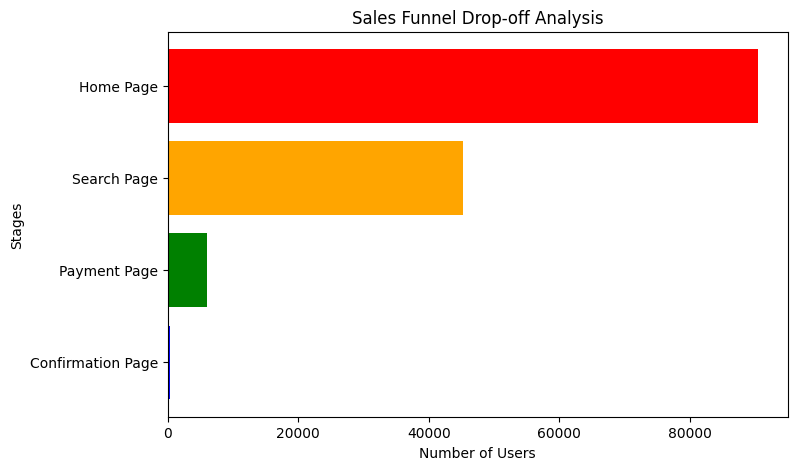

In [320]:
import matplotlib.pyplot as plt


stages = funnel_df.index[::-1]
values = funnel_df["Users"][::-1]


plt.figure(figsize=(8, 5))
plt.barh(stages, values, color=['blue', 'green', 'orange', 'red'])
plt.xlabel("Number of Users")
plt.ylabel("Stages")
plt.title("Sales Funnel Drop-off Analysis")


plt.show()

## **Interactive Funnel Visualization**

In [321]:
import plotly.express as px

fig = px.funnel(
    funnel_df,
    x='Users',
    y=funnel_df.index,
    text='Users',
    title="E-commerce Funnel Analysis",
)

fig.update_traces(textposition="inside", textinfo="value+percent initial")
fig.show()

**From the Funnel chart above we can see that:**

**Only 50% of customers get to search page, 13.3% get to payment page from search page(7% from home page) and only 7.5% of customers get to payment confirmation page from payment page. overall conversion falls do down that is 0.5% which is very abnormal one**

**The Funnel doesn’t look very healthy for me.**

**We lost too many customers on the transformation from search page to payment page and the transformation from payment page to payment confirmation page.**


## **Visualizing Drop-off Rates by Stage**

In [322]:
fig2 = px.bar(
    funnel_df,
    x=funnel_df.index,
    y='Drop-off Rate (%)',
    text='Drop-off Rate (%)',
    title="Drop-off Rate by Stage",
)
fig2.show()


Basically, we saw that a *ton* of people drop off before they buy anything. Like, they come to the home page, but then they just leave somewhere along the way.

The biggest problems seem to be when people go from looking for something (the search page) to actually paying for it (the payment page), and then *again* when they're trying to confirm their payment. Lots of people are just bouncing at those points.

Overall, hardly anyone who starts on the home page actually ends up buying something. It's a really low conversion rate.

This tells us that even though we're getting people to the site, something's seriously wrong in the steps they take to buy stuff. We really need to figure out why people are leaving at those specific stages and make it easier for them to complete their purchase.

## **Segmentation Analysis**

To dig into the reasons, we have to do segmentation analysis to segment the data and see which section perform the worst concerning to conversion rate.



  ### **Trend Analysis:**

  lets check how conversion changed over time.

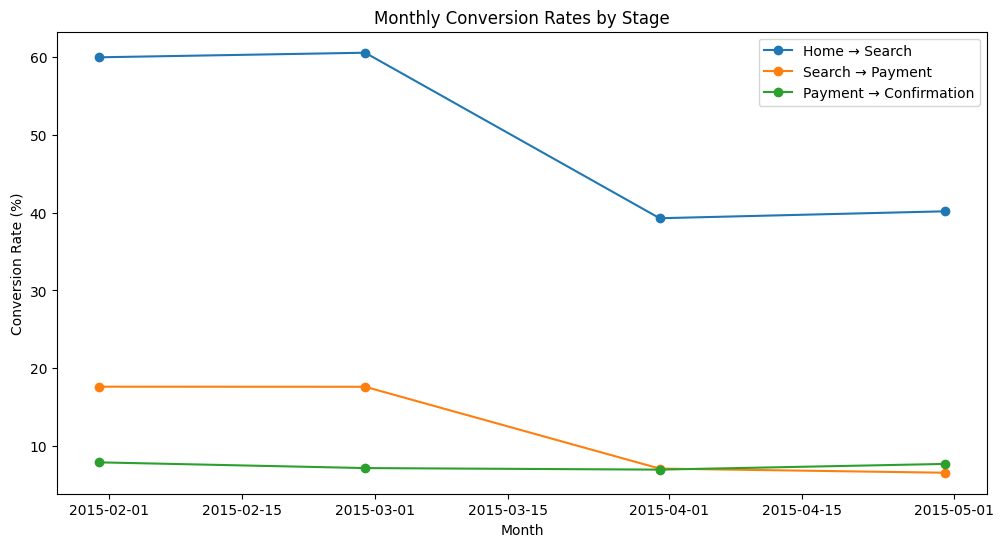

In [323]:
import matplotlib.pyplot as plt

# Convert the 'date' column to datetime objects
merged_df['date'] = pd.to_datetime(merged_df['date'])

# ---- STEP 2: Monthly Conversion Rates ----
def calc_rates(group):
    # Correctly count users at each stage by checking for non-zero values
    total_home = group[group['page'] != 0]['user_id'].nunique()
    total_search = group[group['page_search'] != 0]['user_id'].nunique()
    total_payment = group[group['page_payment'] != 0]['user_id'].nunique()
    total_confirm = group[group['page_confirmation'] != 0]['user_id'].nunique()

    return pd.Series({
        "Home → Search": (total_search / total_home) * 100 if total_home else 0,
        "Search → Payment": (total_payment / total_search) * 100 if total_search else 0,
        "Payment → Confirmation": (total_confirm / total_payment) * 100 if total_payment else 0,
    })

monthly_conv = merged_df.groupby(pd.Grouper(key='date', freq='ME')).apply(calc_rates, include_groups=False).reset_index()

# ---- Plot Conversion Rate Trends ----
plt.figure(figsize=(12,6))
for col in ["Home → Search", "Search → Payment", "Payment → Confirmation"]:
    plt.plot(monthly_conv['date'], monthly_conv[col], marker='o', label=col)

plt.title("Monthly Conversion Rates by Stage")
plt.xlabel("Month")
plt.ylabel("Conversion Rate (%)")
plt.legend()
plt.show()

Clearly, there is a HUGE DROP of conversion rate from home page to search page on Mar 1 and also a CLEAR DROP of conversion rate from payment page to confirmation page on Mar 1 as well.

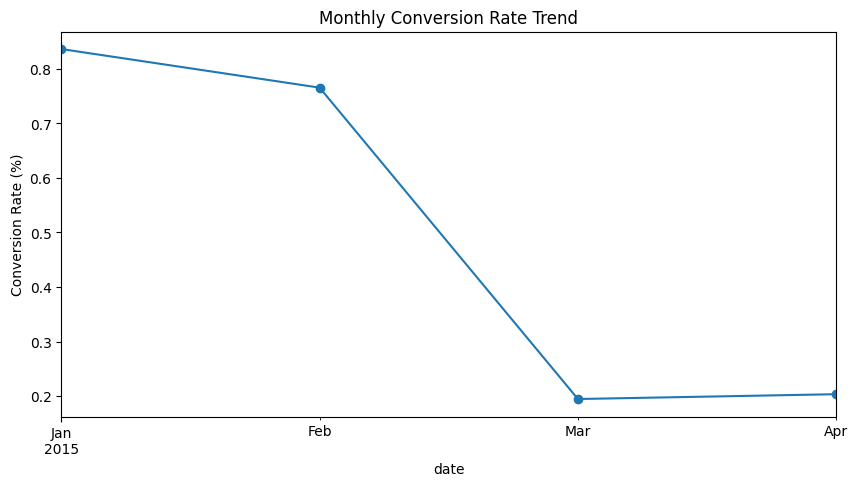

In [324]:
merged_df['date'] = pd.to_datetime(merged_df['date'])

conversion_trend = (
    merged_df.groupby(merged_df['date'].dt.to_period("M"))['page_confirmation']
    .apply(lambda x: (x != 0).sum()) / merged_df.groupby(merged_df['date'].dt.to_period("M"))['page']
    .apply(lambda x: (x != 0).sum())
) * 100

conversion_trend.plot(kind="line", marker="o", figsize=(10,5))
plt.title("Monthly Conversion Rate Trend")
plt.ylabel("Conversion Rate (%)")
plt.show()

We can clealry catcg that there is huge loss of users from feb 0.85% to march 0.2% month, it seems somethng is off during month of march falling around 0.2%, we need to dig into march month situations and stats to get insights on why huge conversion rate loss

We can clearly see a significant drop in the overall conversion rate from approximately 0.85% in February to 0.2% in March. This indicates a major issue occurred during March that severely impacted the conversion funnel. Further investigation into the specific events, changes, or issues that happened in March is crucial to understand the cause of this substantial loss in conversion.

### **Customer Segmentation:**

We should get better of understanding of which group of customers are mainly causing the decrease of conversion rate, that leads to our customer segmentation analysis.

**Based on Gender Group:**

In [325]:

funnel_gender = merged_df.groupby("sex")[["page","page_search","page_payment","page_confirmation"]].count()


funnel_gender = funnel_gender.rename(columns={
    "page":"Home Page",
    "page_search":"Search Page",
    "page_payment":"Payment Page",
    "page_confirmation":"Confirmation Page"
}).T

print("Funnel Stage Counts by Gender:\n")
print(funnel_gender)



Funnel Stage Counts by Gender:

sex                Female   Male
Home Page           45075  45325
Search Page         45075  45325
Payment Page        45075  45325
Confirmation Page   45075  45325


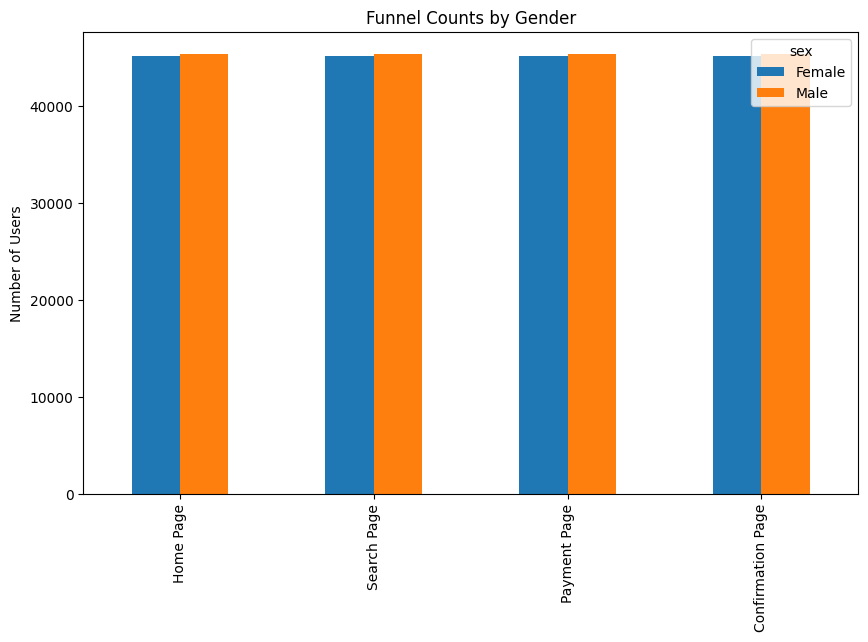

In [326]:

funnel_gender.plot(kind='bar', figsize=(10,6))
plt.title("Funnel Counts by Gender")
plt.ylabel("Number of Users")
plt.show()

**We can see that the above bar chart is quite balanced, meaning that gender might not be a factor that drive the decrease of conversion rate as having relatively same number of customers at each stage for both genders.**

In [327]:
import plotly.express as px

# Reset index to use 'sex' as a column for plotting
funnel_gender_reset = funnel_gender.reset_index()
funnel_gender_reset = funnel_gender_reset.rename(columns={'index': 'Stage'})

# Melt the DataFrame to long format for Plotly Express
funnel_gender_melted = funnel_gender_reset.melt(id_vars='Stage', var_name='Gender', value_name='Users')

# Create the funnel chart
fig = px.funnel(
    funnel_gender_melted,
    x='Users',
    y='Stage',
    color='Gender',
    title="Funnel Analysis by Gender",
)

fig.update_traces(textposition="inside", textinfo="value")
fig.show()




 **It seems gender might not be factor which causing drop of conersion rate since the both genders are moving in same direction, and the funnel chart is quite balanced.**

In [328]:
# Calculate stage-by-stage conversion rates for each gender
conversion_rates = {}

for gender, group in merged_df.groupby("sex"):
    # Correctly count users at each stage by checking for non-zero values
    total_home = group[group['page'] != 0]['user_id'].nunique()
    total_search = group[group['page_search'] != 0]['user_id'].nunique()
    total_payment = group[group['page_payment'] != 0]['user_id'].nunique()
    total_confirm = group[group['page_confirmation'] != 0]['user_id'].nunique()

    conversion_rates[gender] = {
        "Home → Search": round((total_search/total_home)*100, 2) if total_home else 0,
        "Search → Payment": round((total_payment/total_search)*100, 2) if total_search else 0,
        "Payment → Confirmation": round((total_confirm/total_payment)*100, 2) if total_payment else 0,
        "Home → Confirmation": round((total_confirm/total_home)*100, 2) if total_home else 0
    }

import pandas as pd
conversion_rates_df = pd.DataFrame(conversion_rates)
print("\nStage-by-Stage Conversion Rates by Gender (%):\n")
print(conversion_rates_df)


Stage-by-Stage Conversion Rates by Gender (%):

                        Female   Male
Home → Search            50.31  49.69
Search → Payment         13.67  13.01
Payment → Confirmation    7.77   7.20
Home → Confirmation       0.53   0.47


**we can see that there isn't a significant difference in conversion rates between male and female users at any stage of the funnel. This suggests that gender is likely not a major factor contributing to the overall low conversion rate or the drop-offs at specific stages.**

**Comparision of conversion rate through time of Gender.**

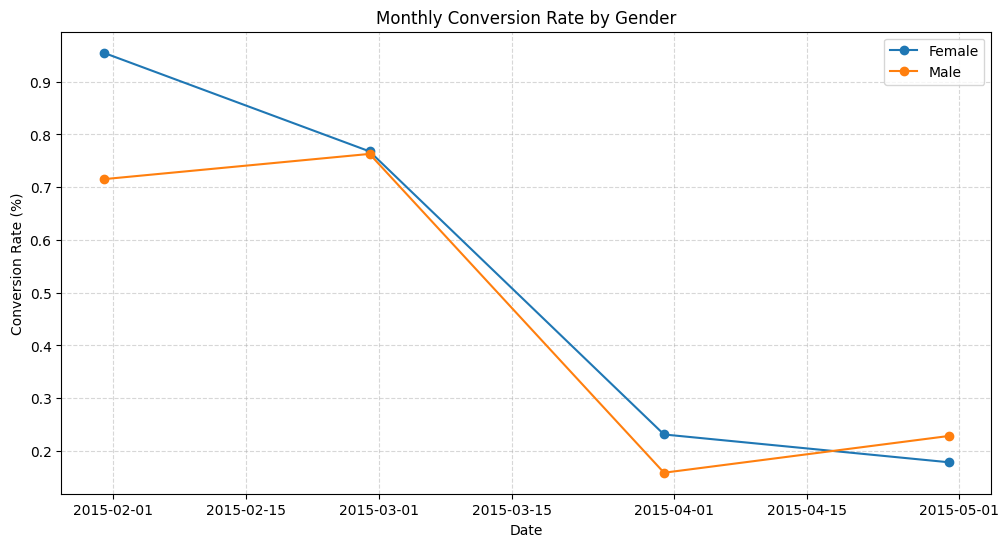

In [329]:
monthly_conv_gender = merged_df.set_index('date')
monthly_conv_gender.index = pd.to_datetime(monthly_conv_gender.index)
monthly_conv_gender = monthly_conv_gender.groupby([pd.Grouper(freq='ME'), 'sex']).apply(
    lambda x: x[x['page_confirmation'] != 0]['user_id'].nunique() / x[x['page'] != 0]['user_id'].nunique() * 100 if x[x['page'] != 0]['user_id'].nunique() else 0,
    include_groups=False # Added to address DeprecationWarning
).reset_index(name='conversion_rate')

plt.figure(figsize=(12,6))
for gender in monthly_conv_gender['sex'].unique():
    temp = monthly_conv_gender[monthly_conv_gender['sex']==gender]
    plt.plot(temp['date'], temp['conversion_rate'], label=gender, marker='o')

plt.title("Monthly Conversion Rate by Gender")
plt.xlabel("Date")
plt.ylabel("Conversion Rate (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**we can see that there is no huge distinction between the trend of conversion rate of Male group and Female group, they all changed in same direction. Now can conclude that gender isn't a primary factor driving significant differences in how the conversion rate changes over time**



### **Based on Device:**
we should also compare the difference between mobile and desktop users.




In [330]:
# Funnel counts by Device
funnel_device = merged_df.groupby("device")[["page","page_search","page_payment","page_confirmation"]].count()

# Rename columns for clarity
funnel_device = funnel_device.rename(columns={
    "page":"Home Page",
    "page_search":"Search Page",
    "page_payment":"Payment Page",
    "page_confirmation":"Confirmation Page"
}).T

print("Funnel Stage Counts by Device:\n")
print(funnel_device)


Funnel Stage Counts by Device:

device             Desktop  Mobile
Home Page            60200   30200
Search Page          60200   30200
Payment Page         60200   30200
Confirmation Page    60200   30200



Desktop has about 60k Home Page visitors, nearly double Mobile (~30k).

But at later funnel stages, Mobile catches up and even exceeds Desktop at the Payment and Confirmation stages.

Suggests Desktop users are dropping off disproportionately as they move down the funnel.






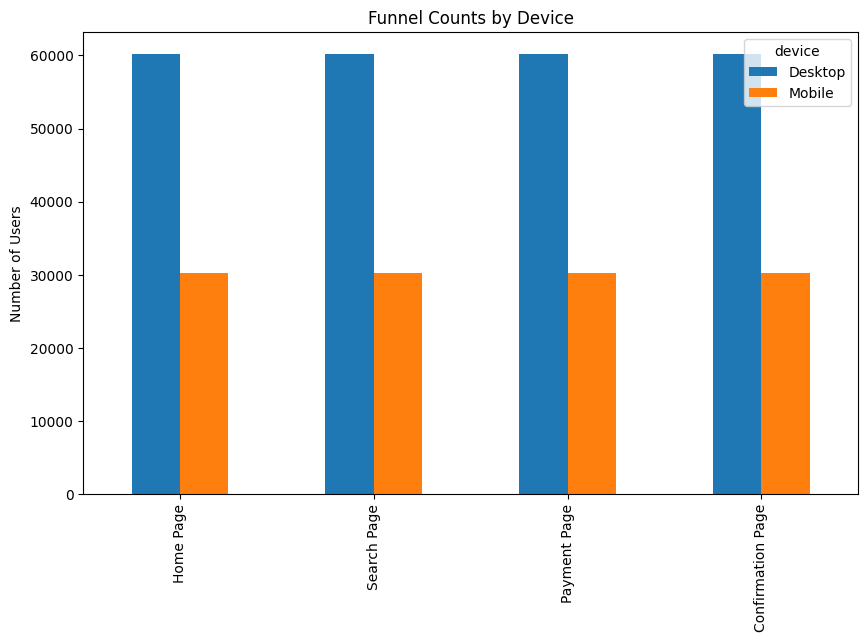

In [331]:
funnel_device.plot(kind='bar', figsize=(10,6))
plt.title("Funnel Counts by Device")
plt.ylabel("Number of Users")
plt.show()


**We can see that there is distinction between the numbers of users using mobile and desktop at each stage, I think may be desktop users causing the drift the dropping conversion rate.**

In [332]:
import plotly.express as px

# Reset index for plotting
funnel_device_reset = funnel_device.reset_index()
funnel_device_reset = funnel_device_reset.rename(columns={'index': 'Stage'})

# Melt to long format
funnel_device_melted = funnel_device_reset.melt(id_vars='Stage', var_name='Device', value_name='Users')

# Funnel chart
fig = px.funnel(
    funnel_device_melted,
    x='Users',
    y='Stage',
    color='Device',
    title="Funnel Analysis by Device",
)

fig.update_traces(textposition="inside", textinfo="value")
fig.show()


Unlike the segmented funnel of gender, this funnel segmented by Devices is very unbalanced, Few things to keep in mind:

1.   More users are using Desktop rather than the mobile.
2.   Desktop conversion rate changed more significant than mobile on payment page.




In [333]:
# Calculate stage-by-stage conversion rates for each device
conversion_rates = {}

for device, group in merged_df.groupby("device"):
    total_home = group[group['page'] != 0]['user_id'].nunique()
    total_search = group[group['page_search'] != 0]['user_id'].nunique()
    total_payment = group[group['page_payment'] != 0]['user_id'].nunique()
    total_confirm = group[group['page_confirmation'] != 0]['user_id'].nunique()

    conversion_rates[device] = {
        "Home → Search": round((total_search/total_home)*100, 2) if total_home else 0,
        "Search → Payment": round((total_payment/total_search)*100, 2) if total_search else 0,
        "Payment → Confirmation": round((total_confirm/total_payment)*100, 2) if total_payment else 0,
        "Home → Confirmation": round((total_confirm/total_home)*100, 2) if total_home else 0
    }

import pandas as pd
conversion_rates_df = pd.DataFrame(conversion_rates)
print("\nStage-by-Stage Conversion Rates by device (%):\n")
print(conversion_rates_df)


Stage-by-Stage Conversion Rates by device (%):

                        Desktop  Mobile
Home → Search             50.00    50.0
Search → Payment          10.00    20.0
Payment → Confirmation     4.98    10.0
Home → Confirmation        0.25     1.0


while both device types have a 50% conversion from Home to Search, Desktop users have significantly lower conversion rates than Mobile users at the later stages of the funnel (Search to Payment and Payment to Confirmation).

we can see how conversion rates differ between Desktop and Mobile users at each stage of the funnel,that mobile users have a much lower conversion rate from the payment page to confirmation, suggesting potential usability issues on mobile devices during the final purchase step.

This suggests there might be usability issues or other friction points specifically affecting Desktop users as they move from searching for a product to completing the purchase.


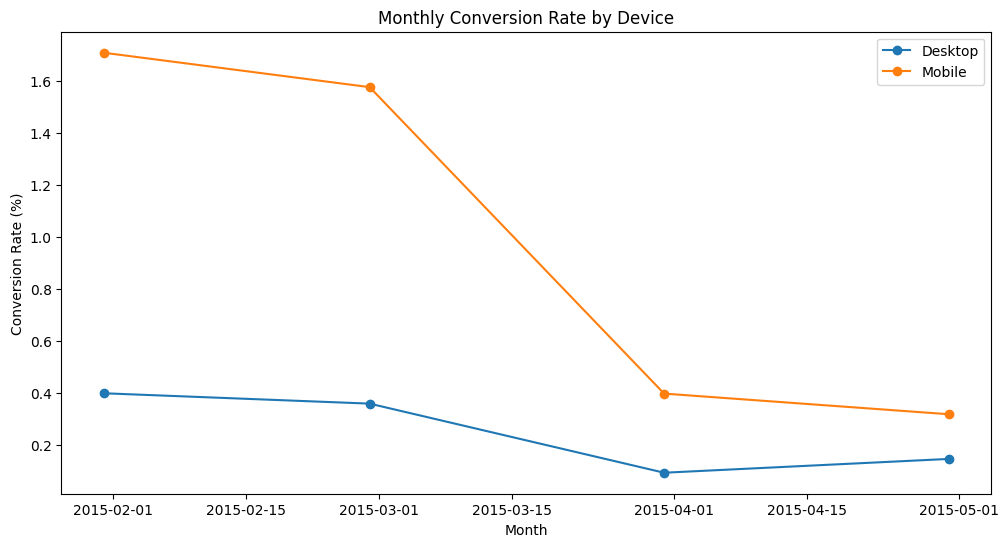

In [334]:
# Monthly conversion rate by device
monthly_conv_device = merged_df.set_index('date')
monthly_conv_device.index = pd.to_datetime(monthly_conv_device.index)
monthly_conv_device = monthly_conv_device.groupby([pd.Grouper(freq='ME'), 'device']).apply(
    lambda x: x[x['page_confirmation'] != 0]['user_id'].nunique() / x[x['page'] != 0]['user_id'].nunique() * 100 if x[x['page'] != 0]['user_id'].nunique() else 0,
    include_groups=False
).reset_index(name='conversion_rate')

# Plot line chart
plt.figure(figsize=(12,6))
for dev in monthly_conv_device['device'].unique():
    temp = monthly_conv_device[monthly_conv_device['device']==dev]
    plt.plot(temp['date'], temp['conversion_rate'], label=dev, marker='o')

plt.title("Monthly Conversion Rate by Device")
plt.ylabel("Conversion Rate (%)")
plt.xlabel("Month")
plt.legend()
plt.show()

From the monthly conversion rate trend by device plot, we can see how the conversion rates for Desktop and Mobile users change over time. This allows us to identify if there are any seasonal patterns, significant shifts in conversion for a particular device, or if the trends for both devices are similar or diverging.

The overall conversion rate from the Home Page to the Confirmation Page is much lower for Desktop users (0.25%) compared to Mobile users (1.0%).

There was a sharp drop in conversion rates for both devices around March 1st, indicating a significant issue occurred like bugs then.

Mobile is performing better than Desktop over the months in terms of conversion rate.

If company wants to improve, they should fix Desktop checkout flow and also push more Mobile traffic, since Mobile converts better.






## **Conclusion**

After our analysis, two clear focus areas emerged: acquiring the right users and improving conversion at key funnel stages.

1. Acquire New Users

Home page visits are volatile — e.g., spikes observed around Feb 1st. These may coincide with promotions, new launches, or A/B experiments. Doubling down on what worked during those peaks could boost steady acquisition.

Currently, 60%+ of traffic comes from Desktop. Since Mobile converts better (≈20% vs 10% on Desktop in Search → Payment), increasing Mobile traffic could directly improve overall conversion without changing UX yet.

2. Improve Conversion Rate

Situation:

Major funnel leaks at Search → Payment (13%) and Payment → Confirmation (7.5%).

A sharp dip on March 1st suggests a potential system outage, release bug, or failed experiment.

Desktop users underperform vs. Mobile, especially at checkout.

Actions:

Investigate March 1st outage → check release logs, error reports, or experiment rollouts.

Audit Payment & Confirmation flows (especially on Desktop): use heatmaps, session replays, or UX testing to uncover blockers.

Redesign or optimize Desktop Search → Payment journey, aligning it with Mobile’s stronger performance.

Introduce progressive nudges/reminders (cart reminders, trust signals, easier payment options) to reduce drop-offs at checkout.